# Brain Tumor Detector

## Get and Load Dataset

In [5]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [6]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=454874e8-126d-4b79-9531-3e1cc211ade5
To: /content/brain_tumor.zip
100% 156M/156M [00:02<00:00, 72.0MB/s]


In [7]:
!unzip -q brain_tumor.zip

In [ ]:
"""import zipfile

# Open the zip file
with zipfile.ZipFile('brain_tumor.zip', 'r') as zip_ref:
    # Extract all files, overwriting if needed
    zip_ref.extractall('./', members=None, pwd=None)"""

In [4]:
ls -l

total 152156
-rw-r--r-- 1 root root 155791278 Apr  5 11:33 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Apr  3 13:25 sample_data/
drwxr-xr-x 6 root root      4096 Apr  5 11:33 Testing/
drwxr-xr-x 6 root root      4096 Apr  5 11:33 Training/


In [ ]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

In [ ]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

In [ ]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

In [ ]:
#!pip install tensorflow==2.9.0

## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import datasets, layers, models
import keras

print('TF Version:', tf.__version__)

TF Version: 2.15.0


## Utility functions to create dataset generators

In [9]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [4]:
train_ds, val_ds = prepare_train_and_val_datasets()

NotFoundError: Could not find directory ./Training

In [ ]:
"""
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))"""

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds, epochs=20,
    validation_data=val_ds,callbacks=[early_stopping]
)

y_true, y_pred = eval_model_on_test(model)

Epoch 1/20
143/143 [==============================] - 10s 41ms/step - loss: 0.7731 - accuracy: 0.6829 - val_loss: 0.5055 - val_accuracy: 0.8074
Epoch 2/20
143/143 [==============================] - 6s 40ms/step - loss: 0.4574 - accuracy: 0.8188 - val_loss: 0.3455 - val_accuracy: 0.8695
Epoch 3/20
143/143 [==============================] - 6s 41ms/step - loss: 0.3440 - accuracy: 0.8737 - val_loss: 0.2703 - val_accuracy: 0.9151
Epoch 4/20
143/143 [==============================] - 6s 40ms/step - loss: 0.2791 - accuracy: 0.8998 - val_loss: 0.3422 - val_accuracy: 0.8625
Epoch 5/20
143/143 [==============================] - 7s 47ms/step - loss: 0.2140 - accuracy: 0.9201 - val_loss: 0.2305 - val_accuracy: 0.9186
Epoch 6/20
143/143 [==============================] - 8s 53ms/step - loss: 0.1753 - accuracy: 0.9365 - val_loss: 0.2158 - val_accuracy: 0.9247
Epoch 7/20
143/143 [==============================] - 13s 90ms/step - loss: 0.1383 - accuracy: 0.9499 - val_loss: 0.2606 - val_accuracy: 0.91

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:03<00:31,  3.15s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:03<00:12,  1.37s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:06,  1.22it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:03,  1.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:03<00:02,  2.48it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:03<00:01,  3.21it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  3.78it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:04<00:00,  4.59it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:04<00:00,  5.36it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:04<00:00,  6.00it/s]

1/1 [==============================] - 0s 76ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 13ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.12s/it]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:05,  1.66it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:03,  2.23it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:02,  2.62it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:01,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:02<00:01,  3.07it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:01,  3.30it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:03<00:01,  2.38it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:03<00:00,  2.51it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:03<00:00,  2.83it/s]

1/1 [==============================] - 0s 20ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


              precision    recall  f1-score   support

      glioma       0.92      0.93      0.93       300
  meningioma       0.92      0.85      0.88       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.95      0.94      1311



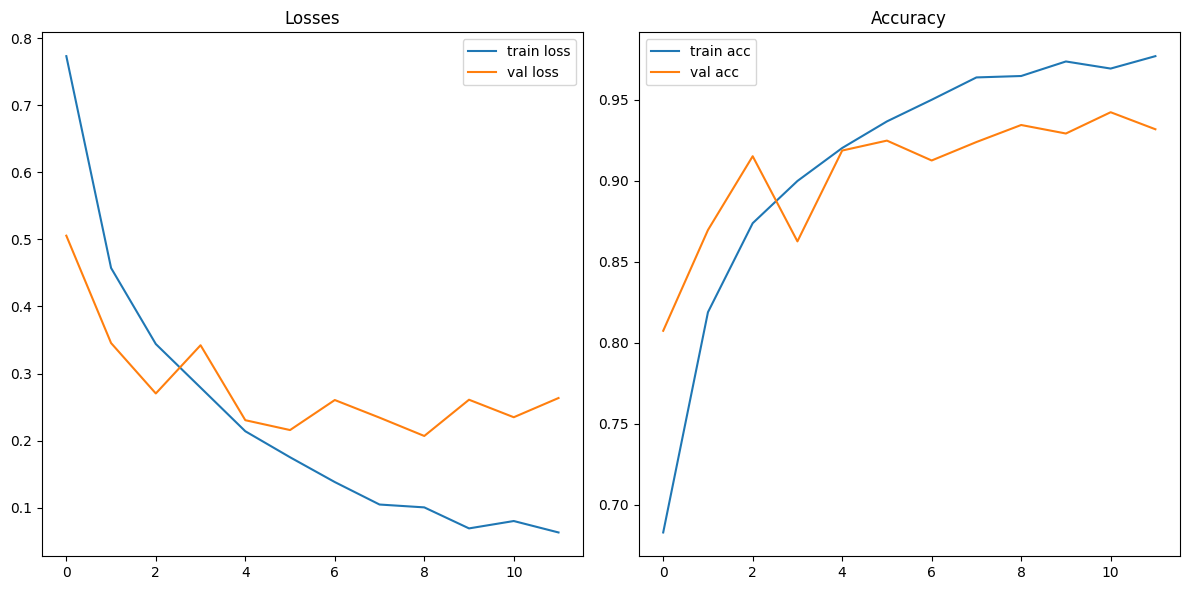

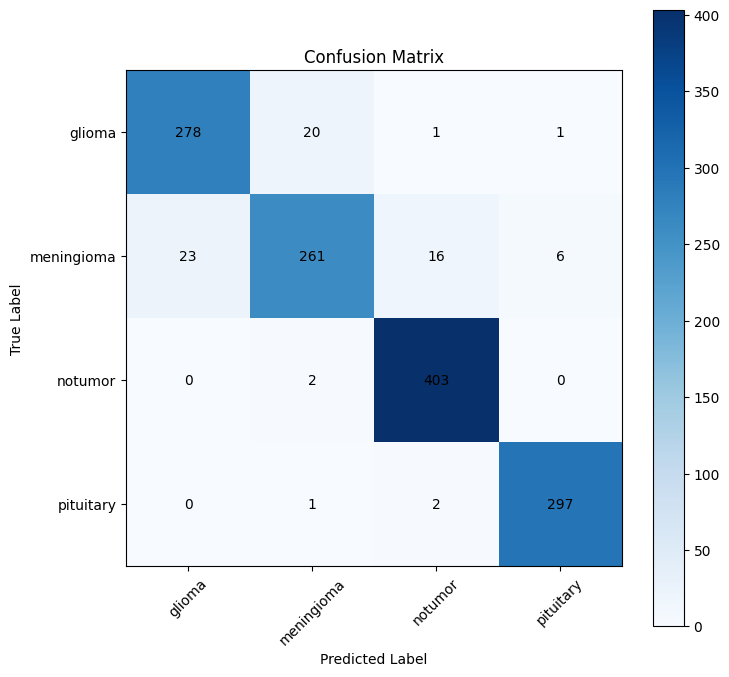

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier.h5')

In [ ]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

# Transfer learning -- VGG16

In [32]:
train_ds, val_ds = prepare_train_and_val_datasets()
"""train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    #.map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))"""

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


'train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))\n                    #.map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))\n                        .shuffle(2000)\n                        .prefetch(buffer_size=tf.data.AUTOTUNE))'

In [ ]:
"""train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_up_down(image), label))  # Randomly flip images vertically
             .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.2), label))  # Randomly adjust brightness
             .map(lambda image, label: (tf.image.random_saturation(image, lower=0.5, upper=1.5), label))  # Randomly adjust saturation
             .map(lambda image, label: (tf.image.random_hue(image, max_delta=0.2), label))  # Randomly adjust hue
             .map(lambda image, label: (tf.image.random_crop(image, size=[100, 100, 3]), label))  # Randomly crop images
             .map(lambda image, label: (tf.image.random_rotation(image, 45), label))  # Randomly rotate images
             .map(lambda image, label: (tf.image.random_flip_left_right(image), label))  # Randomly flip images horizontally
             .map(lambda image, label: (tf.image.central_crop(image, central_fraction=0.8), label))  # Randomly perform central cropping
             .shuffle(2000)
             .prefetch(buffer_size=tf.data.AUTOTUNE))"""

In [1]:
# Load pre-trained VGG16 model
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional base
pretrained_model.trainable = False

# Create a new model by adding custom layers on top of the pre-trained model
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(4)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds, epochs=20,
    validation_data=val_ds,callbacks=[early_stopping]
)

y_true, y_pred = eval_model_on_test(model)

NameError: name 'tf' is not defined

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 54ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:13,  1.30s/it]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:06,  1.43it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:04,  1.71it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:02<00:03,  1.90it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:02,  2.24it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:03<00:02,  2.44it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:03<00:01,  2.40it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:03<00:01,  2.44it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:04<00:00,  2.77it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:04<00:00,  2.71it/s]

1/1 [==============================] - 0s 24ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


              precision    recall  f1-score   support

      glioma       0.92      0.88      0.90       300
  meningioma       0.87      0.90      0.88       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.99      0.96      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



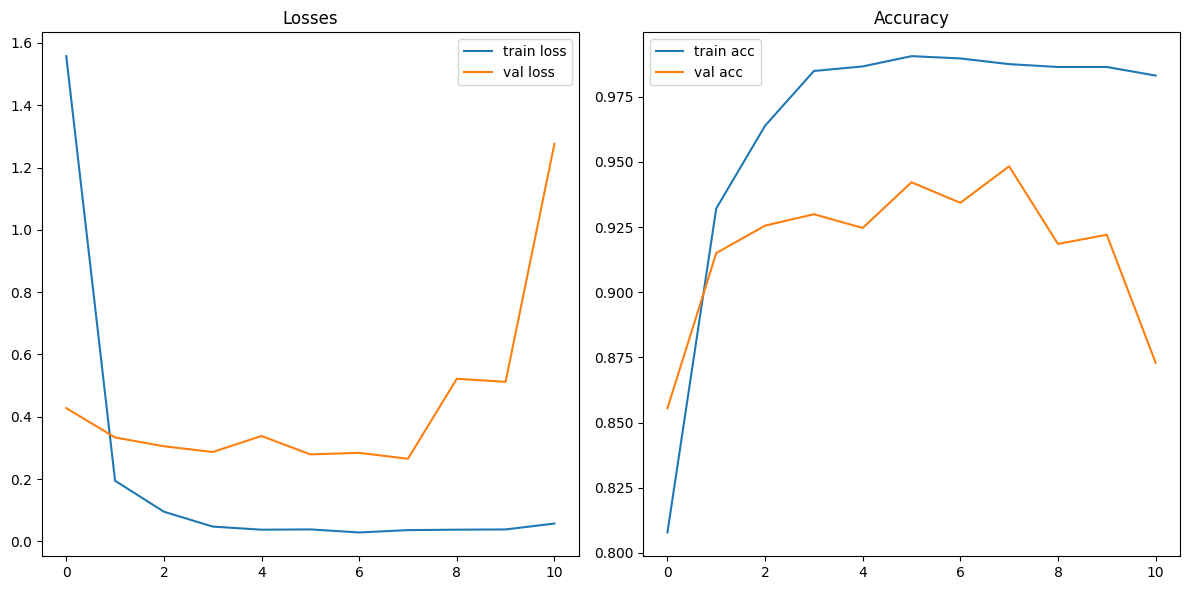

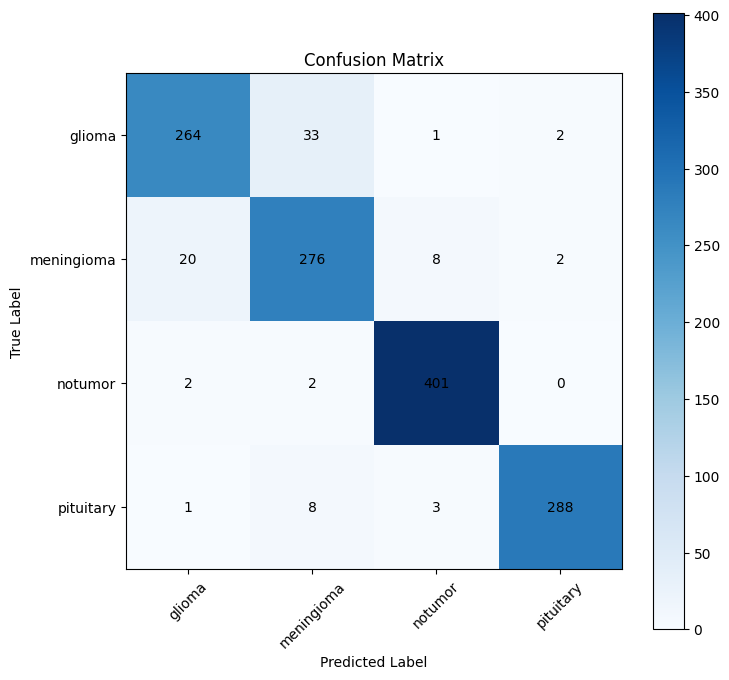

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier.h5')

# Transfer leanring -- ResNet

In [17]:
train_ds, val_ds = prepare_train_and_val_datasets()
"""train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    #.map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))"""

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [12]:
# Load pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional base
pretrained_model.trainable = False

# Create a new model by adding custom layers on top of the pre-trained model
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.25),
    tf.keras.layers.Dense(4)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds, epochs=20,
    validation_data=val_ds, callbacks=[early_stopping]
)

y_true, y_pred = eval_model_on_test(model)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
143/143 [==============================] - 16s 69ms/step - loss: 0.5002 - accuracy: 0.8186 - val_loss: 0.2681 - val_accuracy: 0.8993
Epoch 2/10
143/143 [==============================] - 8s 51ms/step - loss: 0.2315 - accuracy: 0.9153 - val_loss: 0.2384 - val_accuracy: 0.9046
Epoch 3/10
143/143 [==============================] - 8s 55ms/step - loss: 0.1766 - accuracy: 0.9354 - val_loss: 0.1926 - val_accuracy: 0.9247
Epoch 4/10
143/143 [==============================] - 8s 54ms/step - loss: 0.1322 - accuracy: 0.9497 - val_loss: 0.1926 - val_accuracy: 0.9299
Epoch 5/10
143/143 [==============================] - 7s 49ms/step - loss: 0.1030 - accuracy: 0.9600 - val_loss: 0.2575 - val_accuracy: 0.9212
Epoch 6/10
143/143 [==============================] - 8s 54ms/step - loss: 0.0847 - accuracy: 0.9707 - val_loss: 0.1875 - val_accuracy: 0.9343
Epoch 7/10
143/143 [==============================] - 7s 51ms/step - loss: 0

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 47ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:22,  2.25s/it]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:10,  1.17s/it]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:05,  1.34it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:03,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:03<00:02,  2.31it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:03<00:01,  2.73it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:03<00:01,  3.09it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:04<00:00,  3.43it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:04<00:00,  3.71it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:04<00:00,  3.86it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 56ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:06,  1.30it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:04,  1.66it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:02<00:03,  1.91it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:02,  2.35it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:03<00:02,  2.41it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:03<00:01,  2.81it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:03<00:01,  2.73it/s]

4/4 [==============================] - 0s 41ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:04<00:00,  2.94it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:04<00:00,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


              precision    recall  f1-score   support

      glioma       0.98      0.90      0.94       300
  meningioma       0.92      0.93      0.92       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.96      1311
weighted avg       0.96      0.96      0.96      1311



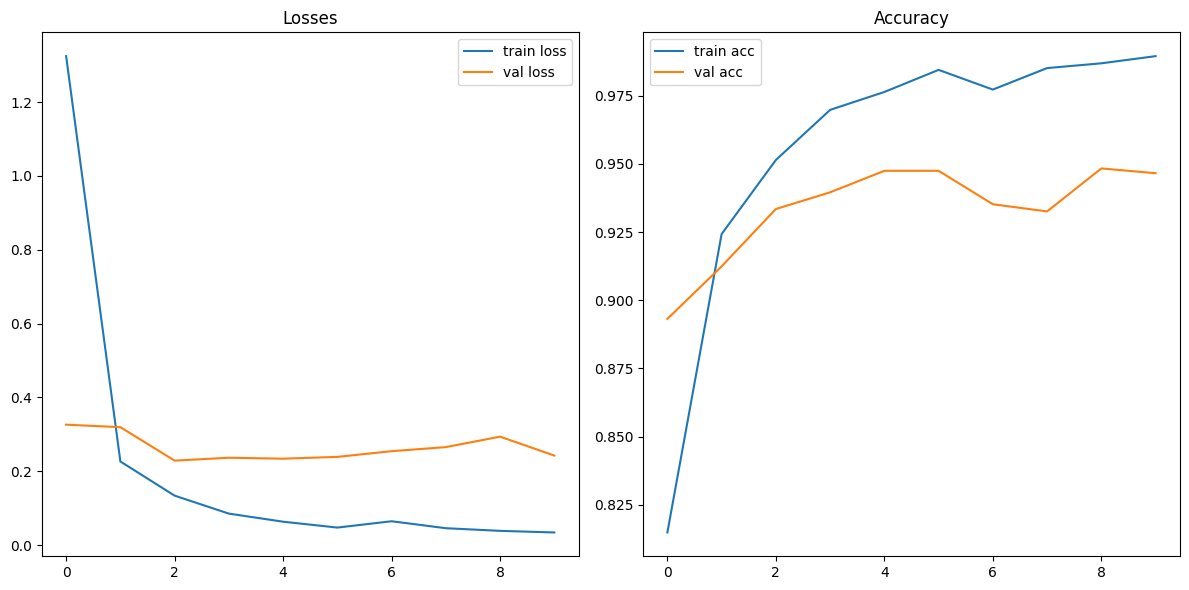

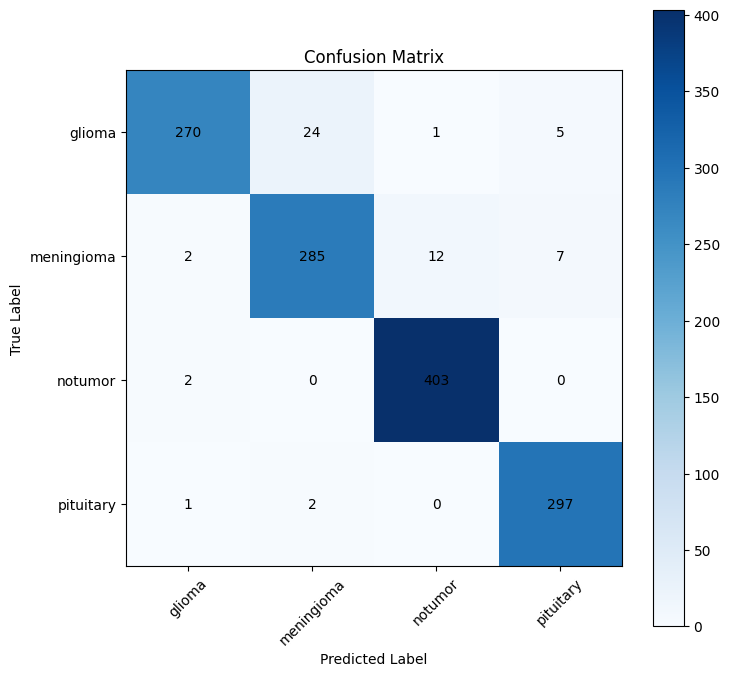

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier.h5')